In [2]:
import sys, os, time
from pathlib import Path
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import cv2

%matplotlib inline

In [3]:
def humansize(nbytes):
    '''From https://stackoverflow.com/questions/14996453/python-libraries-to-calculate-human-readable-filesize-from-bytes'''
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

## Determine paths and directories

In [4]:
path_imagenet_val_dataset = Path("data") # path/to/data/
path_labels = path_imagenet_val_dataset / "ILSVRC2012_validation_ground_truth.txt"
path_synset_words = path_imagenet_val_dataset / "synset_words.txt"
path_meta = path_imagenet_val_dataset / "meta.mat"
dir_images = path_imagenet_val_dataset / "val" # path/to/images/directory

In [5]:
image_paths = sorted(glob(str(dir_images/"*")))
n_images = len(image_paths)

n_images

50000

## Preprocess images

In [23]:
def load_images(image_paths, returned_shard, n_shards=5):
    """ loads images into memory. It only load and returns images of the 'returned_shard'.
        image_paths: a list of paths to images
        n_shards: number of shards to loaded images be divided.
        returned_shard: the part of images to be returned. 0 <= returned_shard < n_shards
    """
    assert 0 <= returned_shard < n_shards, "The argument returned_shard must be between 0 and n_shards"
    
    shard_size = len(image_paths) // n_shards
    sharded_image_paths = image_paths[returned_shard*shard_size:(returned_shard+1)*shard_size] if returned_shard < n_shards - 1 \
                     else image_paths[returned_shard*shard_size:]
    
    images_list = np.zeros((len(sharded_image_paths), 224, 224, 3), dtype=np.uint8)
    
    for i, image_path in enumerate(sharded_image_paths):
        
        # Load (in BGR channel order)
        image = cv2.imread(image_path)
        
        # Resize
        new_height, new_width = np.array(image.shape[:2]) * 256 // np.min(image.shape[:2])      
        image = cv2.resize(image, (new_height, new_width), interpolation=cv2.INTER_CUBIC)
        
        # Crop
        start_y, start_x = np.array(image.shape[:2]) // 2 - (224 // 2)
        image = image[start_y:start_y + 224, start_x:start_x + 224]
        assert image.shape[0] == 224 and image.shape[1] == 224
        
        # Convert image color channels
        images_list[i,:,:,:] = image[:,:,::-1]
        
    return images_list

## Load and save images in 50 shards

In [24]:
n_shards = 50

for i in range(n_shards):
    
    images = load_images(image_paths, returned_shard=i, n_shards=n_shards)
    
    if i == 0:
        print("Total memory allocated for loading images:", humansize(images.nbytes))
    
    np.save(str(path_imagenet_val_dataset / "x_val_{}.npy".format(i+1)), images)
    
    if (i + 1) * 100 // n_shards % 10 == 0:
        print("{:.0f}% Completed.".format((i+1)/n_shards*100))
    
    images = None

Total memory allocated for loading images: 143.55 MB
10% Completed.
20% Completed.
30% Completed.
40% Completed.
50% Completed.
60% Completed.
70% Completed.
80% Completed.
90% Completed.
100% Completed.


## Mapping between different label types

In [13]:
meta = scipy.io.loadmat(str(path_meta))
original_idx_to_synset = {}
synset_to_name = {}

for i in range(1000):
    ilsvrc2012_id = int(meta["synsets"][i,0][0][0][0])
    synset = meta["synsets"][i,0][1][0]
    name = meta["synsets"][i,0][2][0]
    original_idx_to_synset[ilsvrc2012_id] = synset
    synset_to_name[synset] = name

synset_to_keras_idx = {}
keras_idx_to_name = {}
with open(str(path_synset_words),"r") as f:
    for idx, line in enumerate(f):
        parts = line.split(" ")
        synset_to_keras_idx[parts[0]] = idx
        keras_idx_to_name[idx] = " ".join(parts[1:])

convert_original_idx_to_keras_idx = lambda idx: synset_to_keras_idx[original_idx_to_synset[idx]]

In [14]:
with open(str(path_labels),"r") as f:
    y_val = f.read().strip().split("\n")
    y_val = list(map(int, y_val))
    y_val = np.array([convert_original_idx_to_keras_idx(idx) for idx in y_val])

In [30]:
np.save(str(path_imagenet_val_dataset/"y_val.npy"), y_val)

## Show example images

### Load a shard of validation images

In [28]:
idx_shard = 4
x_val = np.load(str(path_imagenet_val_dataset/"x_val_{}.npy").format(idx_shard))

### Show a few images

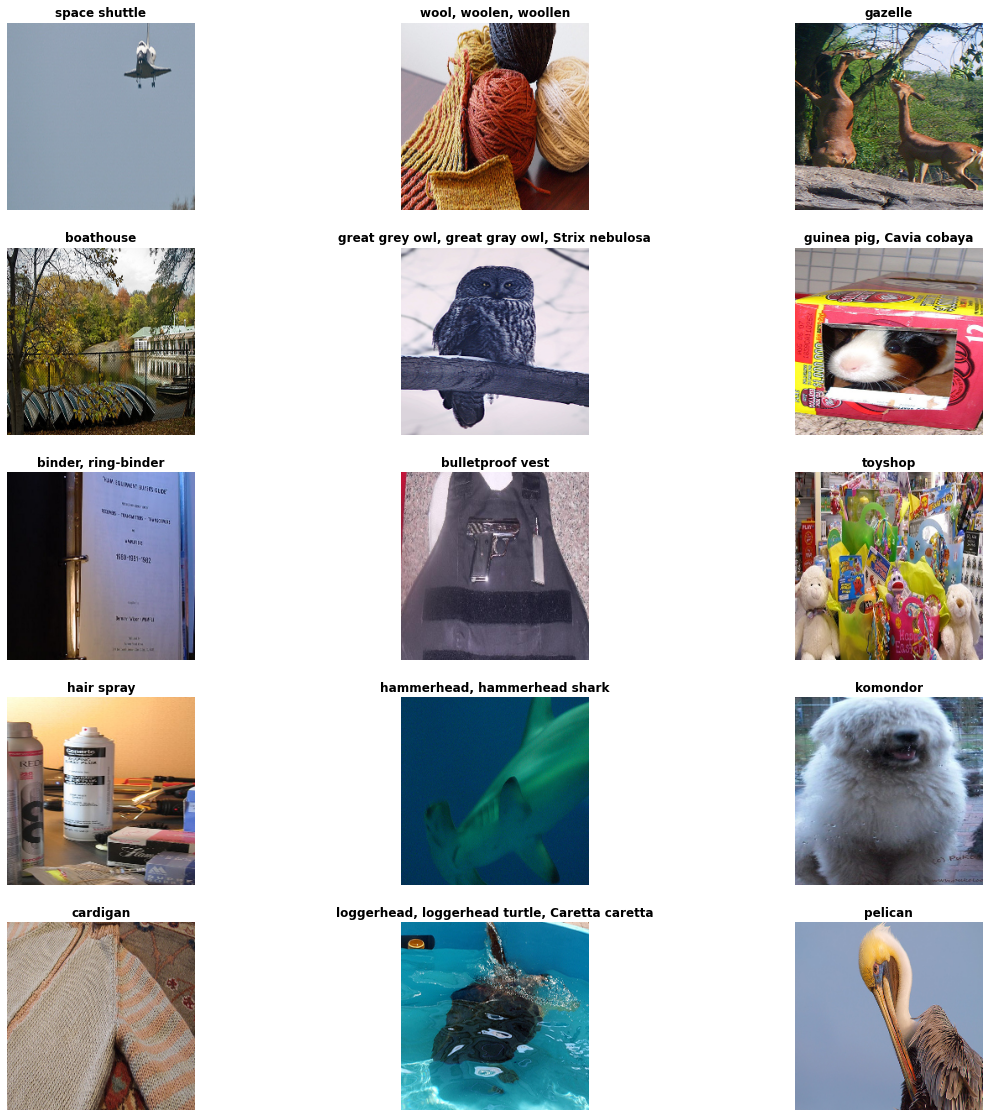

In [29]:
n_images2show = 15
n_cols = 3
n_rows = 15 // n_cols
figsize = (20, 20)

indices = np.random.choice(x_val.shape[0], size=n_images2show, replace=False)
images = x_val[indices] / 255.

fig, ax = plt.subplots(figsize=figsize, nrows=n_rows, ncols=n_cols)
for i, axi in enumerate(ax.flat):
    
    axi.imshow(images[i])
    label_index = (idx_shard - 1) * (n_images // n_shards) + indices[i]
    axi.set_title(keras_idx_to_name[y_val[label_index]], y=.9, fontdict={'fontweight':'bold'}, pad=10)
    axi.set_axis_off()

plt.show()